In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

sns.set_style('whitegrid')

# Problem definition

Cluster museums based on traveler type and tags, in order to recommend types of museums to visit (i.e. which categories).

# Load the data

In [2]:
#input
df = pd.read_csv('data/museum_data.csv')
df = df.set_index(['MuseumName', 'Continent', 'SubRegion','Country'])
df.head()
df_copy = df.copy()

# Feature Engineering 

In [3]:
# define columns ranges
traveler_columns = ['Families', 'Couples', 'Solo', 'Business', 'Friends']
categories = list(df.loc[:,'Ancient Ruins':'Zoos & Aquariums'].columns)
tags = list(df.loc[:,'on display':'life size'].columns)

# instead of looking at the ratios of traveler types, identify the top traveler type per museum, because that can be used as a selector in the app
df['TopTraveler'] = df[traveler_columns].idxmax(axis=1)
df_top_travelers = df['TopTraveler'].str.get_dummies()
df_top_travelers.columns = ['TopCouples','TopFamilies','TopFriends','TopSolo']
df = pd.concat([df, df_top_travelers], axis=1)

In [4]:
# convert tags data to ints so logical comparisons work properly
df.loc[:,tags] = df.loc[:,tags].astype(int)

# create combinations of similar tags to reduce dimensionality
df['special exhibit'] = (df['special exhibits']) | (df['special exhibitions']) | (df['traveling exhibits']) | (df['changing exhibits']) | (df['rotating exhibits'])
df['interactive'] = (df['interactive exhibits']) | (df['interactive displays']) | (df['hands on activities'])
df['family'] = (df['all ages']) | (df['great for kids']) | (df['whole family']) | (df['kids and adults'])
df['art'] = (df['art lovers']) | (df['works of art']) | (df['modern art']) | (df['old masters']) | (df['sculpture garden'])
df['learn'] = (df['great place to learn']) | (df['learn something'])
df['display'] = (df['on display']) | (df['displays'])
df['history2'] = (df['old west']) | (df['early days']) | (df['interesting artifacts']) | (df['history lesson']) | (df['history buff']) | (df['lots of history']) | (df['great history'])
df['natural'] = (df['natural history']) | (df['stuffed animals'])

## other features I tried that weren't helpful in the end:
# df['2 hours'] = (df['couple of hours']) | (df['few hours']) | (df['two hours'])
# df['audio'] = (df['audio guide']) | (df['audio tour'])
# df['free'] = (df['free admission']) | (df['free entry']) | -(df['entrance fee']) | -(df['admission'])
# df['collection'] = (df['private collection']) | (df['amazing collection']) | (df['nice collection']) | (df['permanent collection'])
# df['Popular'] = (df['ReviewCount']>10000)

C:\Users\Kirsten\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [5]:
# remove NaNs
df = df.dropna()

# select the columns
tags_to_use = ['special exhibit', 'interactive', 'family', 'audio guide', 'art', 'display', 'rainy day', 'natural', 'eye opening', 'learn', 'history2', 'permanent collection']
numeric_columns = ['TopCouples','TopFamilies','TopFriends','TopSolo']

X_columns = tags_to_use + numeric_columns
df = df[X_columns]

# # normalize the columns
# df_norm = df.copy()
# for col in X_columns:
#     df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

df_norm = df.copy()
scaler = StandardScaler()
scaler.fit(df_norm)
df_norm = scaler.transform(df_norm)
df_norm = pd.DataFrame(df_norm, columns=df.columns)

df_norm = df_norm.set_index(df.index)

print(df.shape)
df_norm.head()

(1593, 16)


C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kirsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.


,,,,special exhibit,interactive,family,audio guide,art,display,rainy day,natural,eye opening,learn,history2,permanent collection,TopCouples,TopFamilies,TopFriends,TopSolo
MuseumName,Continent,SubRegion,Country,,,,,,,,,,,,,,,,
The Field Museum,Americas,Northern America,USA,2.218543,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378
Smithsonian National Museum of Natural History,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378
American Museum of Natural History,Americas,Northern America,USA,2.218543,-0.443672,-0.513111,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378
National Naval Aviation Museum,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378
National Mississippi River Museum & Aquarium,Americas,Northern America,USA,-0.450746,2.253919,1.948895,-0.321225,-0.344499,0.998119,-0.462792,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378


# Model Training

In [6]:
k = 8
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

{0, 1, 2, 3, 4, 5, 6, 7}
Counter({2: 704, 5: 224, 3: 224, 0: 166, 4: 147, 1: 79, 6: 40, 7: 9})


In [7]:
df_results = df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_

In [8]:
df_norm.head()

,,,,special exhibit,interactive,family,audio guide,art,display,rainy day,natural,eye opening,learn,history2,permanent collection,TopCouples,TopFamilies,TopFriends,TopSolo,cluster
MuseumName,Continent,SubRegion,Country,,,,,,,,,,,,,,,,,
The Field Museum,Americas,Northern America,USA,2.218543,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,1
Smithsonian National Museum of Natural History,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,1
American Museum of Natural History,Americas,Northern America,USA,2.218543,-0.443672,-0.513111,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,5
National Naval Aviation Museum,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,3
National Mississippi River Museum & Aquarium,Americas,Northern America,USA,-0.450746,2.253919,1.948895,-0.321225,-0.344499,0.998119,-0.462792,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,3


In [9]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(kmeans.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['SubRegion']).most_common(5))

# n_clusters = len(set(kmeans.labels_))
# for col in X_columns:
#     print(col)
#     i = 1
#     plt.figure(figsize=(16,3))
#     for cluster in sorted(set(kmeans.labels_)):
#         plt.subplot(1, n_clusters, i)
#         plt.xlim([0,df_results[col].max()])
#         plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
#         i += 1
#     plt.show()

[('Northern America', 138), ('Northern Europe', 7), ('Latin America and the Caribbean', 5), ('Southern Europe', 4), ('Eastern Asia', 3)]
[('Northern America', 47), ('Northern Europe', 14), ('Western Europe', 7), ('Australia and New Zealand', 4), ('Eastern Europe', 2)]
[('Northern America', 328), ('Western Europe', 97), ('Northern Europe', 76), ('Southern Europe', 75), ('Eastern Europe', 37)]
[('Northern America', 176), ('Northern Europe', 20), ('Western Europe', 11), ('Eastern Asia', 5), ('Australia and New Zealand', 4)]
[('Northern America', 124), ('Western Europe', 13), ('Southern Europe', 3), ('Latin America and the Caribbean', 3), ('Eastern Asia', 2)]
[('Northern America', 187), ('Northern Europe', 7), ('Western Europe', 6), ('Eastern Asia', 6), ('South-eastern Asia', 5)]
[('Northern America', 19), ('South-eastern Asia', 4), ('Eastern Asia', 4), ('Western Asia', 3), ('Northern Europe', 3)]
[('Eastern Asia', 3), ('Eastern Europe', 3), ('Northern Europe', 1), ('South-eastern Asia', 1

In [10]:
# add the clusters to the original dataset in order to analyze the museum categories in each cluster
df_copy2 = pd.concat([df_copy.reset_index(),df_results['cluster']],axis=1)

# count the number of museums of each category per cluster
df_cluster_categories = df_copy2.groupby('cluster')[categories].sum().T

# print the top museum categories and frequency per cluster
for i in range(8):
    print('Cluster',i)
    print(df_cluster_categories[i].sort_values(ascending=False).head(10))
    print('')

Cluster 0
Museums                           162
Specialty Museums                  91
History Museums                    74
Sights & Landmarks                 20
Historic Sites                     14
Art Museums                        13
Military Museums                   11
Libraries                           5
Traveler Resources                  5
Points of Interest & Landmarks      4
Name: 0, dtype: int64

Cluster 1
Museums                         79
Specialty Museums               39
Natural History Museums         28
History Museums                 19
Science Museums                  5
Art Museums                      4
Children's Museums               4
Sights & Landmarks               3
Shopping                         2
Observatories & Planetariums     2
Name: 1, dtype: int64

Cluster 2
Museums                           678
Specialty Museums                 426
History Museums                   186
Art Museums                       147
Sights & Landmarks                 71
Hist

In [11]:
# normalize the results
df_results_norm = df_results.copy()
for col in X_columns:
    df_results_norm[col] = StandardScaler().fit_transform(df_results_norm[col].values.reshape(-1, 1))

print(df.shape)
df_norm.head()

(1593, 16)


C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Kirsten\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was

,,,,special exhibit,interactive,family,audio guide,art,display,rainy day,natural,eye opening,learn,history2,permanent collection,TopCouples,TopFamilies,TopFriends,TopSolo,cluster
MuseumName,Continent,SubRegion,Country,,,,,,,,,,,,,,,,,
The Field Museum,Americas,Northern America,USA,2.218543,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,1
Smithsonian National Museum of Natural History,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,-0.462792,4.348850,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,1
American Museum of Natural History,Americas,Northern America,USA,2.218543,-0.443672,-0.513111,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,5
National Naval Aviation Museum,Americas,Northern America,USA,-0.450746,-0.443672,1.948895,-0.321225,-0.344499,0.998119,2.160796,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,3
National Mississippi River Museum & Aquarium,Americas,Northern America,USA,-0.450746,2.253919,1.948895,-0.321225,-0.344499,0.998119,-0.462792,-0.229946,-0.149882,-0.197836,-0.409742,-0.336463,-1.438528,1.545756,-0.160489,-0.075378,3


In [12]:
# Analyze the normalized centroids
df_results_norm.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6,7
special exhibit,-0.31,0.19,-0.16,-0.02,1.46,-0.26,-0.12,0.44
interactive,-0.09,0.03,-0.26,1.33,-0.41,-0.11,-0.38,-0.14
family,-0.31,0.98,-0.36,1.89,-0.50,-0.46,-0.45,-0.24
audio guide,-0.07,-0.15,0.20,-0.31,-0.02,-0.24,0.02,0.82
art,-0.29,-0.30,0.10,-0.32,0.94,-0.29,-0.02,0.02
display,-0.04,-0.01,0.02,-0.27,0.52,-0.00,-0.60,0.55
rainy day,-0.00,0.70,-0.08,0.40,-0.07,-0.29,-0.40,-0.17
natural,-0.23,4.35,-0.23,-0.23,-0.23,-0.23,-0.23,0.28
eye opening,-0.03,-0.15,0.05,-0.15,-0.15,0.12,0.02,0.61
learn,0.25,0.07,-0.09,0.20,-0.20,0.04,-0.20,-0.20



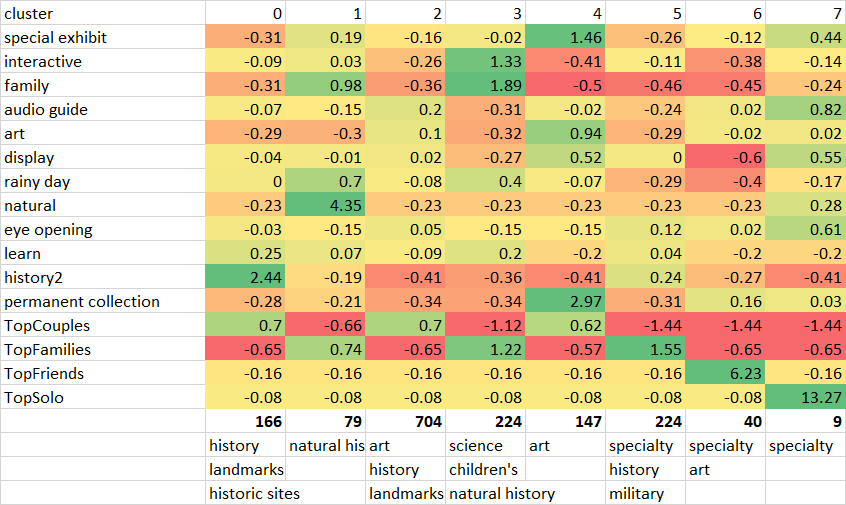

# Model Evaluation

In [13]:
import pickle

# save the scaler to file
filename = 'scaler16.pkl'
pickle.dump(scaler, open(filename, 'wb'))

# save the model to file
filename = 'model16.pkl'
pickle.dump(kmeans, open(filename, 'wb'))